 # <b> Advanced Machine Learning - Project <br></b>
Nina Graves (1801989), Patricial Merschel (1981700)

The following Notebook is divided into different sections: <br>
- Discovery: Identify columns and data sets to remove in order to reduce the size of the data
- Pre-Processing: Analysis of remaining LC-Data and preparing it for modelling
- Modelling

After running the instanciation all parts can be run individually (as long as every part was run once to create the files that are loaded)
<br>

<b> Instanciation </b>

In [4]:
import itertools
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
## run whenever you want to run anything within the notebook
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from dateutil import relativedelta
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import NuSVC

pd.set_option("display.max.columns", None)

# Pre-Defined Parameters
THRESHOLD = 70
SIGNIFICANCE = 0.1 # anything affecting more than SIGNIFICANCE % of data is considered significant

# functions for different sections

def identify_classes (df):
    """Adds column calles "class" with entries "completed", "not_completed" and na"""

    df.loc[df["loan_status"]=="Fully Paid", "Class"] = "repaid"
    df.loc[df["loan_status"]=="Charged Off", "Class"] = "not_repaid"
    df.loc[df["loan_status"]=="Default", "Class"] = "not_repaid"

    return df

def count_entries_in_cols(df, threshold=None, percentage=False, na=False, entry=None):
    """pass frame and receive number of different values / number of nas of each col as 1D frame,
    if threshold: additionally list of cols with a count larger than threshold"""

    if percentage > 1:
        percentage = percentage/100

    if na:
        count = df.isna().sum().to_frame()
        count = count.rename(columns={0:"count"})

    else:
        count = pd.DataFrame(index=df.columns, columns=["count"])
        for col in df.columns:
            if isinstance(entry, int) or isinstance(entry, int):
                count.loc[col, "count"] = len(df[df[col]==entry])
            else:
                unique_entries = df[col].value_counts()
                count.loc[col, "count"] = len(unique_entries)

    if threshold:
        if percentage:
            threshold = len(df)*percentage
        cols_above_thresh = list(count.loc[count["count"] >= threshold].index)
    else:
        cols_above_thresh=None

    return count, cols_above_thresh

def save_list_to_file(filename, list_to_save):
    """Save all elements of a list to an individual line in a txt file"""
    with open(f"{filename}.txt", "w") as file:
        for element in list_to_save:
            file.write(element + "\n")
    return

def load_textfile_to_list(filename):
    """Pass textfile with separate entries per line and receive list"""
    with open(f"{filename}.txt", "r") as file:
        file_list = file.read().splitlines()

    return file_list

# Part 0 - Discovery

In [2]:
peak_raw_data = pd.read_csv("accepted_2007_to_2018Q4.csv.gz", compression="gzip", nrows=1000)
peak_raw_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [3]:
peak_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 151 entries, id to settlement_term
dtypes: float64(115), int64(1), object(35)
memory usage: 1.2+ MB


In [4]:
na_info_peak, _ = count_entries_in_cols(peak_raw_data, na=True)
na_info_peak

,count
id,0
member_id,1000
loan_amnt,0
funded_amnt,0
funded_amnt_inv,0
...,...
settlement_status,978
settlement_date,978
settlement_amount,978
settlement_percentage,978


In [5]:
#### get info about total data set, find out if there are enough entries that aren't active
#### or whether we have to approximate
total_amounts = pd.Series(index=["total_entries", "total_repaid", "total_not_repaid", "total_active"], data=[0,0,0,0])
nas_cols = pd.DataFrame(index=peak_raw_data.columns, columns=["count"])

for chunk in pd.read_csv("accepted_2007_to_2018Q4.csv.gz", compression="gzip", chunksize=5000, low_memory=False):
    chunk = identify_classes(chunk)
    total_amounts["total_entries"] += len(chunk)
    total_amounts["total_repaid"] += len(chunk[chunk["Class"]=="repaid"])
    total_amounts["total_not_repaid"] += len(chunk[chunk["Class"]=="not_repaid"])

    na_chunk,_ = count_entries_in_cols(chunk, na=True)
    nas_cols = nas_cols.add(na_chunk, fill_value=0)

([<matplotlib.patches.Wedge at 0x1974cd7bdc0>,
 [Text(0.08185750358960302, 1.0969500212434833, 'total_repaid'),
  Text(-1.0724474447655248, -0.24465583625962647, 'total_not_repaid'),
  Text(0.3237846321289946, -1.0512675739302015, 'total_active')],
 [Text(0.04464954741251073, 0.5983363752237181, '47.6%'),
  Text(-0.584971333508468, -0.13344863795979625, '11.9%'),
  Text(0.17660979934308793, -0.5734186766892008, '40.5%')])

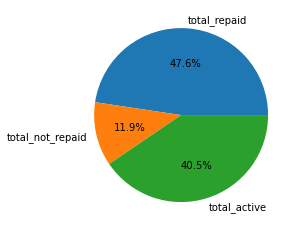

In [6]:
#### identify and display number of loans with ongoing payments (=> active) ####
total_amounts["total_active"] = total_amounts["total_entries"] - total_amounts["total_repaid"] \
                                - total_amounts["total_not_repaid"]

data_distribution = total_amounts[1:]
plt.pie(data_distribution, labels=data_distribution.index, autopct='%1.1f%%')

In [7]:
#### look at cols with many nas ####
val_na = THRESHOLD/100*total_amounts["total_entries"]
cols_many_nas = nas_cols.loc[nas_cols["count"] > val_na]
cols_many_nas

# => some columns have the same amount of nas => hypothesis: because these columns relate to a similar topic

,count
annual_inc_joint,2139991
debt_settlement_flag_date,2226455
deferral_term,2249784
desc,2134634
dti_joint,2139995
hardship_amount,2249784
hardship_dpd,2249784
hardship_end_date,2249784
hardship_last_payment_amount,2249784
hardship_length,2249784


In [8]:
#### see how large "groups" of columns are
values = cols_many_nas.value_counts()
values

count  
2249784    13
2152680    10
2226455     6
1679926     1
1741000     1
1901545     1
2134634     1
2139991     1
2139995     1
2144971     1
2152681     1
2154517     1
2224759     1
2252050     1
2260701     1
dtype: int64

In [9]:
### take a closer look at largest group
groups = [x[0] for x in list(values.index[:3])]
group1 = cols_many_nas[cols_many_nas["count"]==groups[0]]
group1
#### all info regarding hardships.
# Assumption: people with a hardship flag at the time of application is rejected.
# => Remove these cols, as this information would not be known when loan is applied for

,count
deferral_term,2249784
hardship_amount,2249784
hardship_dpd,2249784
hardship_end_date,2249784
hardship_last_payment_amount,2249784
hardship_length,2249784
hardship_loan_status,2249784
hardship_payoff_balance_amount,2249784
hardship_reason,2249784
hardship_start_date,2249784


In [10]:
### create a list with the columns containing information on hardships
col_names = nas_cols.index.to_list()
cols_to_remove_hardship = [x for x in col_names if "hardship" in x]
cols_to_remove_hardship = list(set(cols_to_remove_hardship + group1.index.to_list()))

In [11]:
### look at second group of columns
group2 = cols_many_nas[cols_many_nas["count"]==groups[1]]
group2
#### all info related to the second applicxant of a joint application.
#### => We only focus on individual applications as the joint data can be handled in different ways and is not comparable

,count
sec_app_chargeoff_within_12_mths,2152680
sec_app_collections_12_mths_ex_med,2152680
sec_app_earliest_cr_line,2152680
sec_app_fico_range_high,2152680
sec_app_fico_range_low,2152680
sec_app_inq_last_6mths,2152680
sec_app_mort_acc,2152680
sec_app_num_rev_accts,2152680
sec_app_open_acc,2152680
sec_app_open_act_il,2152680


In [12]:
### create list of groups belonging to theis group
cols_joint = [x for x in col_names if ("sec" in x)]
cols_joint

['sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_earliest_cr_line',
 'sec_app_fico_range_high',
 'sec_app_fico_range_low',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_mths_since_last_major_derog',
 'sec_app_num_rev_accts',
 'sec_app_open_acc',
 'sec_app_open_act_il',
 'sec_app_revol_util']

In [13]:
### look at third major grouping
group3 = cols_many_nas[cols_many_nas["count"]==groups[2]]
group3
#### all info regarding hardships.
# Assumption: people with a settlement flag at the time of application is rejected.
# Remove these cols

,count
debt_settlement_flag_date,2226455
settlement_amount,2226455
settlement_date,2226455
settlement_percentage,2226455
settlement_status,2226455
settlement_term,2226455


In [14]:
# list of group 3
cols_to_remove_settlement = [x for x in col_names if "settlement" in x]

In [15]:
#### look at all remeaining cols with many nas
group4_na_count = [x[0] for x in list(values.index[3:])]
group4 = cols_many_nas[cols_many_nas["count"].isin(group4_na_count)]
group4
#### majoritry also associated with joint applications

,count
annual_inc_joint,2139991
desc,2134634
dti_joint,2139995
member_id,2260701
mths_since_last_major_derog,1679926
mths_since_last_record,1901545
mths_since_recent_bc_dlq,1741000
orig_projected_additional_accrued_interest,2252050
revol_bal_joint,2152681
sec_app_mths_since_last_major_derog,2224759


In [16]:
# append list with columns concerning joint applications
cols_joint_app = [x for x in col_names if ("joint" in x)]
cols_joint.extend(cols_joint_app)
cols_joint

['sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_earliest_cr_line',
 'sec_app_fico_range_high',
 'sec_app_fico_range_low',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_mths_since_last_major_derog',
 'sec_app_num_rev_accts',
 'sec_app_open_acc',
 'sec_app_open_act_il',
 'sec_app_revol_util',
 'annual_inc_joint',
 'dti_joint',
 'revol_bal_joint',
 'verification_status_joint']

In [17]:
#### look at remeaining cols with many nas
group5_na_count = [x for x in group4.index.to_list() if not x in cols_joint_app]
group5_na_count
#### ==> member id is irrelevant - drop
#### ==> desc too many different entries - drop
#### ==> number of months relevant! keep!
#### ==> orig_projected_additional_accrued_interest part of hardship => drop

['desc',
 'member_id',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'orig_projected_additional_accrued_interest',
 'sec_app_mths_since_last_major_derog',
 'sec_app_revol_util']

In [18]:
#### create list of all column names we want to drop
cols_to_remove_hardship.append("orig_projected_additional_accrued_interest")
remove = ["desc", "member_id"]
cols_to_remove = remove + cols_to_remove_hardship + cols_to_remove_settlement + cols_joint + ["application_type"]
cols_to_remove

['desc',
 'member_id',
 'hardship_loan_status',
 'hardship_flag',
 'hardship_status',
 'payment_plan_start_date',
 'hardship_end_date',
 'hardship_start_date',
 'hardship_length',
 'deferral_term',
 'hardship_reason',
 'hardship_amount',
 'hardship_payoff_balance_amount',
 'hardship_type',
 'hardship_last_payment_amount',
 'hardship_dpd',
 'orig_projected_additional_accrued_interest',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'settlement_amount',
 'settlement_date',
 'settlement_percentage',
 'settlement_status',
 'settlement_term',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_earliest_cr_line',
 'sec_app_fico_range_high',
 'sec_app_fico_range_low',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_mths_since_last_major_derog',
 'sec_app_num_rev_accts',
 'sec_app_open_acc',
 'sec_app_open_act_il',
 'sec_app_revol_util',
 'annual_inc_joint',
 'dti_joint',
 'revol_bal_joint',
 'verification_status_joint',
 'application_type']

In [19]:
# save this list
save_list_to_file("cols_to_remove", cols_to_remove)

# Part 1 - Pre-Processing

In [20]:
# function for loading and pre-processing
def remove_entries_from_df(df, identifiers_to_remove, cols=False):
    """pass df and a list of either col_names or indices - function removes all entries of list.
    If you want to remove cols: cols=True"""

    if not isinstance(identifiers_to_remove, list):
        identifiers_to_remove = [identifiers_to_remove]

    if cols:
        identifiers_to_remove = [x for x in identifiers_to_remove if x in df.columns]
        df = df.drop(identifiers_to_remove, axis=1)

    else:
        identifiers_to_remove = [x for x in identifiers_to_remove if x in df.index]
        df = df.drop(identifiers_to_remove, axis=1)

    return df

def get_column_info (df):
    """pass df, receive information on the different cols including data type, number of unique entries,
    number of entries that aren't NAs, number of entries that are NAs"""
    column_info = pd.DataFrame()
    unique_values_per_col, _ = count_entries_in_cols(df)
    nas_cols, _ = count_entries_in_cols(df, na=True)
    nas_cols = nas_cols.rename({"count": "Entries_NA"}, axis=1)
    unique_values_per_col = unique_values_per_col.rename({"count": "Entries_Unique"}, axis=1)

    column_info["Type"] = df.dtypes
    column_info["Entries_not_NA"] = df.notna().sum()
    column_info = pd.concat([column_info, nas_cols], axis=1, join="inner")
    column_info = pd.concat([column_info, unique_values_per_col], axis=1, join="inner")

    return column_info

Load and Reduce Data

In [21]:
# load results of previous part and preparation with the meta-data
# we used the LCDataDictionary to identify columns that relate to information on the loan
### as we don't want to use this information to train the model we want to drop it as well
columns_irrelevant_from_meta = load_textfile_to_list("col_names to remove")
columns_irrelevant_from_discovery = load_textfile_to_list("cols_to_remove")

# list of all cols that should be dropped - remove entries in several lists by creating a set
cols_to_remove = list(set(columns_irrelevant_from_meta + columns_irrelevant_from_discovery))
cols_to_remove

['settlement_date',
 'sec_app_revol_util',
 'sec_app_fico_range_high',
 'sec_app_mths_since_last_major_derog',
 'total_rec_late_fee',
 'hardship_end_date',
 'hardship_length',
 'sec_app_inq_last_6mths',
 'hardship_amount',
 'id',
 'debt_settlement_flag_date',
 'total_rec_int',
 'last_pymnt_d',
 'sec_app_collections_12_mths_ex_med',
 'annual_inc_joint',
 'verification_status_joint',
 'total_pymnt',
 'last_fico_range_high',
 'debt_settlement_flag',
 'hardship_flag',
 'settlement_term',
 'sec_app_open_acc',
 'revol_bal_joint',
 'hardship_reason',
 'member_id',
 'last_credit_pull_d',
 'total_rec_prncp',
 'hardship_payoff_balance_amount',
 'settlement_percentage',
 'sec_app_chargeoff_within_12_mths',
 'desc',
 'out_prncp',
 'hardship_last_payment_amount',
 'sec_app_mort_acc',
 'hardship_dpd',
 'url',
 'hardship_loan_status',
 'last_pymnt_amnt',
 'collection_recovery_fee',
 'orig_projected_additional_accrued_interest',
 'hardship_start_date',
 'sec_app_fico_range_low',
 'disbursement_method'

In [22]:
##### Load all data and delete columns and entries we already know we want to drop

# load all data
raw_lc_data =  pd.read_csv("accepted_2007_to_2018Q4.csv.gz", compression="gzip", low_memory=False)

# set binary classes completed and not_completed for all

raw_lc_data = identify_classes(raw_lc_data)

# drop all entries with loans still active
raw_lc_data = raw_lc_data.loc[raw_lc_data["Class"].notna()]

# drop all entries with joint applications
raw_lc_data = raw_lc_data.loc[raw_lc_data["application_type"] == "Individual"]

# drop columns with too many nas and lc loan data
raw_lc_data = remove_entries_from_df(raw_lc_data, cols_to_remove, cols=True)

raw_lc_data.to_csv("Reduced_LC_Data.csv", index=False)

# <b> Analysis and Data Preparation </b>

In [23]:
# load reduced data set
raw_lc_data = pd.read_csv("Reduced_LC_Data.csv", low_memory=False)
raw_lc_data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,Class
0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,n,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,30.0,1.0,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,repaid
1,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,n,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,NaN,1.0,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,repaid
2,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,n,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,w,0.0,NaN,1.0,0.0,0.0,331730.0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,34000.0,2.0,1.0,3.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,12.0,1.0,12.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,repaid
3,11950.0,36 months,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,34000.0,Source Verified,Dec-2015,n,debt_consolidation,Debt consolidation,300xx,GA,10.20,0.0,Oct-1987,690.0,694.0,0.0,NaN,NaN,5.0,0.0,8822.0,68.4,6.0,w,0.0,NaN,1.0,0.0,0.0,12798.0,0.0,1.0,0.0,0.0,338.0,3976.0,99.0,0.0,0.0,4522.0,76.0,12900.0,0.0,0.0,0.0,0.0,2560.0,844.0,91.0,0.0,0.0,338.0,54.0,32.0,32.0,0.0,36.0,NaN,NaN,NaN,0.0,2.0,3.0,2.0,2.0,2.0,4.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,repaid
4,20000.0,36 months,9.17,637.58,B,B2,Vice President of Recruiting Operations,10+ years,MORTGAGE,180000.0,Not Verified,Dec-2015,n,debt_consolidation,Debt consolidation,550xx,MN,14.67,0.0,Jun-1990,680.0,684.0,0.0,49.0,NaN,12.0,0.0,87329.0,84.5,27.0,f,0.0,NaN,1.0,0.0,0.0,360358.0,0.0,2.0,0.0,2.0,18.0,29433.0,63.0,2.0,3.0,13048.0,74.0,94200.0,1.0,0.0,1.0,6.0,30030.0,0.0,102.9,0.0,0.0,142.0,306.0,10.0,10.0,4.0,12.0,NaN,10.0,NaN,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,repaid


([<matplotlib.patches.Wedge at 0x1975ca68340>,
 [Text(-0.8924667315891035, 0.6430420927176256, 'repaid'),
  Text(0.8924667014861293, -0.6430421344970083, 'not_repaid')],
 [Text(-0.4868000354122382, 0.3507502323914321, '80.1%'),
  Text(0.4868000189924341, -0.3507502551801863, '19.9%')])

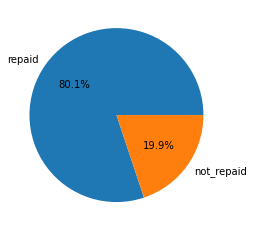

In [24]:
# recheck the distribution of the classes on the remaining entries
values = raw_lc_data["Class"].value_counts()
plt.pie(values, labels=values.index, autopct='%1.1f%%')


In [25]:
### get information about the remaining data concerning the different features
column_info = get_column_info(raw_lc_data)

# take a look at features with few different entries
few_entries = column_info[column_info["Entries_Unique"] <= 5]
few_entries

,Type,Entries_not_NA,Entries_NA,Entries_Unique
term,object,1319544,0,2
verification_status,object,1319544,0,3
pymnt_plan,object,1319544,0,1
initial_list_status,object,1319544,0,2
policy_code,float64,1319544,0,1
num_tl_30dpd,float64,1252017,67527,5
Class,object,1319544,0,2


In [26]:
# display these features
raw_lc_data[few_entries.index]

,term,verification_status,pymnt_plan,initial_list_status,policy_code,num_tl_30dpd,Class
0,36 months,Not Verified,n,w,1.0,0.0,repaid
1,36 months,Not Verified,n,w,1.0,0.0,repaid
2,60 months,Source Verified,n,w,1.0,0.0,repaid
3,36 months,Source Verified,n,w,1.0,0.0,repaid
4,36 months,Not Verified,n,f,1.0,0.0,repaid
...,...,...,...,...,...,...,...
1319539,60 months,Not Verified,n,f,1.0,0.0,repaid
1319540,60 months,Not Verified,n,f,1.0,0.0,repaid
1319541,60 months,Source Verified,n,f,1.0,0.0,not_repaid
1319542,60 months,Not Verified,n,f,1.0,0.0,repaid


In [27]:
# term only uses these 2 entries and they can be transformed to integers and hence don't have to be classified
lc_data = raw_lc_data.copy()
lc_data["term"] = pd.to_numeric(raw_lc_data["term"].str[1:3])

In [28]:
# look at the entries of this feature
raw_lc_data["num_tl_30dpd"].value_counts()
#### indicated number of accounts at least 30 days past due date
#### no action - stays the way it is for now

0.0    1247970
1.0       3831
2.0        183
3.0         26
4.0          7
Name: num_tl_30dpd, dtype: int64

In [29]:
#remove feature that only contain one value
cols_to_delete = column_info[column_info["Entries_Unique"] == 1].index.to_list()
lc_data = remove_entries_from_df(lc_data, cols_to_delete, cols=True)

In [30]:
### one-hot encode initial list status as there are only two entries
# identify whether w of f is the most common entry and assign "1" to this entry
most_common_entry = lc_data.initial_list_status.value_counts().index[0]
other_entry = lc_data.initial_list_status.value_counts().index[1]
lc_data["initial_list_status"] = lc_data["initial_list_status"].map({most_common_entry: 1, other_entry:0})
lc_data = lc_data.rename({"initial_list_status": f"initial_list_status_{most_common_entry}"}, axis = 1)
lc_data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status_w,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,Class
0,3600.0,36,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,1,0.0,30.0,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,repaid
1,24700.0,36,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,1,0.0,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,repaid
2,10400.0,60,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,1,0.0,NaN,0.0,0.0,331730.0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,34000.0,2.0,1.0,3.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,12.0,1.0,12.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,repaid
3,11950.0,36,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,34000.0,Source Verified,Dec-2015,debt_consolidation,Debt consolidation,300xx,GA,10.20,0.0,Oct-1987,690.0,694.0,0.0,NaN,NaN,5.0,0.0,8822.0,68.4,6.0,1,0.0,NaN,0.0,0.0,12798.0,0.0,1.0,0.0,0.0,338.0,3976.0,99.0,0.0,0.0,4522.0,76.0,12900.0,0.0,0.0,0.0,0.0,2560.0,844.0,91.0,0.0,0.0,338.0,54.0,32.0,32.0,0.0,36.0,NaN,NaN,NaN,0.0,2.0,3.0,2.0,2.0,2.0,4.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,repaid
4,20000.0,36,9.17,637.58,B,B2,Vice President of Recruiting Operations,10+ years,MORTGAGE,180000.0,Not Verified,Dec-2015,debt_consolidation,Debt consolidation,550xx,MN,14.67,0.0,Jun-1990,680.0,684.0,0.0,49.0,NaN,12.0,0.0,87329.0,84.5,27.0,0,0.0,NaN,0.0,0.0,360358.0,0.0,2.0,0.0,2.0,18.0,29433.0,63.0,2.0,3.0,13048.0,74.0,94200.0,1.0,0.0,1.0,6.0,30030.0,0.0,102.9,0.0,0.0,142.0,306.0,10.0,10.0,4.0,12.0,NaN,10.0,NaN,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,repaid


Categorical Data

In [31]:
# get updated column information
column_info = get_column_info(lc_data)

# display columns that would be categorical and have many different categories
many_categories = column_info[(column_info["Entries_Unique"] >= 50) & (column_info["Type"] == "object")]
many_categories

,Type,Entries_not_NA,Entries_NA,Entries_Unique
emp_title,object,1237582,81962,374459
issue_d,object,1319544,0,139
title,object,1303497,16047,61682
zip_code,object,1319543,1,943
addr_state,object,1319544,0,51
earliest_cr_line,object,1319544,0,738


In [32]:
###### Transform feature containing info of earliest credit line to int showing how long ago it was opened
# Display the features showing dates
date_cols = ["earliest_cr_line", "issue_d"]
lc_data[date_cols]

,earliest_cr_line,issue_d
0,Aug-2003,Dec-2015
1,Dec-1999,Dec-2015
2,Jun-1998,Dec-2015
3,Oct-1987,Dec-2015
4,Jun-1990,Dec-2015
...,...,...
1319539,Jul-2004,Oct-2016
1319540,Mar-2002,Oct-2016
1319541,Jun-2011,Oct-2016
1319542,Aug-1997,Oct-2016


In [33]:
# transform both cols to datetime
result = lc_data[date_cols].applymap(lambda x: datetime.strptime(x, "%b-%Y"), na_action="ignore")

# calculate time difference in months and save in list
time_difference = [relativedelta.relativedelta(result.loc[index, "issue_d"], result.loc[index, "earliest_cr_line"])
         for index in result.index]
# transform difference into months and store in new column
lc_data["months_since_earliest_cr_line"] = [i.years * 12 + i.months for i in time_difference]
lc_data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status_w,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,Class,months_since_earliest_cr_line
0,3600.0,36,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,1,0.0,30.0,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,repaid,148
1,24700.0,36,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,1,0.0,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,repaid,192
2,10400.0,60,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,1,0.0,NaN,0.0,0.0,331730.0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,34000.0,2.0,1.0,3.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,12.0,1.0,12.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,repaid,210
3,11950.0,36,13.44,405.18,C,C3,Veterinary Tecnician,4 years,RENT,34000.0,Source Verified,Dec-2015,debt_consolidation,Debt consolidation,300xx,GA,10.20,0.0,Oct-1987,690.0,694.0,0.0,NaN,NaN,5.0,0.0,8822.0,68.4,6.0,1,0.0,NaN,0.0,0.0,12798.0,0.0,1.0,0.0,0.0,338.0,3976.0,99.0,0.0,0.0,4522.0,76.0,12900.0,0.0,0.0,0.0,0.0,2560.0,844.0,91.0,0.0,0.0,338.0,54.0,32.0,32.0,0.0,36.0,NaN,NaN,NaN,0.0,2.0,3.0,2.0,2.0,2.0,4.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,repaid,338
4,20000.0,36,9.17,637.58,B,B2,Vice President of Recruiting Operations,10+ years,MORTGAGE,180000.0,Not Verified,Dec-2015,debt_consolidation,Debt consolidation,550xx,MN,14.67,0.0,Jun-1990,680.0,684.0,0.0,49.0,NaN,12.0,0.0,87329.0,84.5,27.0,0,0.0,NaN,0.0,0.0,360358.0,0.0,2.0,0.0,2.0,18.0,29433.0,63.0,2.0,3.0,13048.0,74.0,94200.0,1.0,0.0,1.0,6.0,30030.0,0.0,102.9,0.0,0.0,142.0,306.0,10.0,10.0,4.0,12.0,NaN,10.0,NaN,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,repaid,306


In [34]:
many_categories_collist = [i for i in many_categories.index.to_list() if i!="issue_d"]
# drop all features with too many different entries
lc_data = remove_entries_from_df(lc_data, many_categories_collist, cols=True)
# lc_data.to_csv("Intermediate_Data.csv", index=False)
# lc_data = pd.read_csv("Intermediate_Data.csv", low_memory=False)
drop_later = ["verification_status", "issue_d"]
lc_data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status_w,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,Class,months_since_earliest_cr_line
0,3600.0,36,13.99,123.03,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,debt_consolidation,5.91,0.0,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,1,0.0,30.0,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,repaid,148
1,24700.0,36,11.99,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,small_business,16.06,1.0,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,1,0.0,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,repaid,192
2,10400.0,60,22.45,289.91,F,F1,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,major_purchase,25.37,1.0,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,1,0.0,NaN,0.0,0.0,331730.0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,34000.0,2.0,1.0,3.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,12.0,1.0,12.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,repaid,210
3,11950.0,36,13.44,405.18,C,C3,4 years,RENT,34000.0,Source Verified,Dec-2015,debt_consolidation,10.20,0.0,690.0,694.0,0.0,NaN,NaN,5.0,0.0,8822.0,68.4,6.0,1,0.0,NaN,0.0,0.0,12798.0,0.0,1.0,0.0,0.0,338.0,3976.0,99.0,0.0,0.0,4522.0,76.0,12900.0,0.0,0.0,0.0,0.0,2560.0,844.0,91.0,0.0,0.0,338.0,54.0,32.0,32.0,0.0,36.0,NaN,NaN,NaN,0.0,2.0,3.0,2.0,2.0,2.0,4.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,repaid,338
4,20000.0,36,9.17,637.58,B,B2,10+ years,MORTGAGE,180000.0,Not Verified,Dec-2015,debt_consolidation,14.67,0.0,680.0,684.0,0.0,49.0,NaN,12.0,0.0,87329.0,84.5,27.0,0,0.0,NaN,0.0,0.0,360358.0,0.0,2.0,0.0,2.0,18.0,29433.0,63.0,2.0,3.0,13048.0,74.0,94200.0,1.0,0.0,1.0,6.0,30030.0,0.0,102.9,0.0,0.0,142.0,306.0,10.0,10.0,4.0,12.0,NaN,10.0,NaN,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,repaid,306


Missing Values

In [35]:
##### Analyse features still containing NAs
column_info = get_column_info(lc_data)
column_info[column_info["Entries_NA"]>0]

,Type,Entries_not_NA,Entries_NA,Entries_Unique
emp_length,object,1244776,74768,11
inq_last_6mths,float64,1319543,1,9
mths_since_last_delinq,float64,654215,665329,163
mths_since_last_record,float64,223920,1095624,126
revol_util,float64,1318732,812,1371
collections_12_mths_ex_med,float64,1319488,56,15
mths_since_last_major_derog,float64,347615,971929,173
tot_coll_amt,float64,1252017,67527,12801
tot_cur_bal,float64,1252017,67527,396054
open_acc_6m,float64,512104,807440,19


In [36]:
### identify number of 0-entry per feature
# count 0 in cols
entries_zero, _ = count_entries_in_cols(lc_data, entry=0)

# append number of 0s to df containing information on columns
column_info = pd.concat([column_info, entries_zero], axis=1, join="inner")

# rename column
column_info = column_info.rename({"count": "Entries_0"}, axis=1)

# calculate percentage of na values
column_info["Percentage_NA"] = round(column_info["Entries_NA"]/(column_info["Entries_NA"] + column_info["Entries_not_NA"]), 2)

# store information on features with Nas in separate list
columns_nas = column_info[column_info["Entries_NA"]>0]
columns_nas

,Type,Entries_not_NA,Entries_NA,Entries_Unique,Entries_0,Percentage_NA
emp_length,object,1244776,74768,11,0,0.06
inq_last_6mths,float64,1319543,1,9,753726,0.00
mths_since_last_delinq,float64,654215,665329,163,1719,0.50
mths_since_last_record,float64,223920,1095624,126,678,0.83
revol_util,float64,1318732,812,1371,6642,0.00
collections_12_mths_ex_med,float64,1319488,56,15,1298755,0.00
mths_since_last_major_derog,float64,347615,971929,173,262,0.74
tot_coll_amt,float64,1252017,67527,12801,1060067,0.05
tot_cur_bal,float64,1252017,67527,396054,349,0.05
open_acc_6m,float64,512104,807440,19,207700,0.61


In [37]:
# display features with a significant part of na values
significant_na_count = columns_nas[columns_nas["Percentage_NA"] >= SIGNIFICANCE]
significant_na_count

,Type,Entries_not_NA,Entries_NA,Entries_Unique,Entries_0,Percentage_NA
mths_since_last_delinq,float64,654215,665329,163,1719,0.50
mths_since_last_record,float64,223920,1095624,126,678,0.83
mths_since_last_major_derog,float64,347615,971929,173,262,0.74
open_acc_6m,float64,512104,807440,19,207700,0.61
open_act_il,float64,512105,807439,50,57020,0.61
open_il_12m,float64,512105,807439,19,254203,0.61
open_il_24m,float64,512105,807439,31,119442,0.61
mths_since_rcnt_il,float64,498645,820899,342,245,0.62
total_bal_il,float64,512105,807439,115988,53972,0.61
il_util,float64,443707,875837,235,2848,0.66


In [38]:
values_significant_na_count = significant_na_count["Entries_NA"].value_counts()
features_primary_na_count = columns_nas[columns_nas["Entries_NA"] == values_significant_na_count.index[0]].index.to_list()
features_primary_na_count

# information on installments
# information on open revolving trades and the balance on revolving bank accounts
# personal finance inquiries

['open_act_il',
 'open_il_12m',
 'open_il_24m',
 'total_bal_il',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'inq_fi']

In [39]:
# we have the hypothesis that this data might be missing because the data was only collected after a certain point in time
lc_data["issue_d_year"] = lc_data["issue_d"].str[-4:]
drop_later.append("issue_d_year")
lc_data = lc_data.sort_values(["issue_d_year"])
lc_data["issue_d_year"].unique()

array(['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018'], dtype=object)

In [40]:
entries_na_cols = lc_data[lc_data[features_primary_na_count].isna().all(axis=1)].copy()
entries_na_cols["issue_d_year"].unique()

array(['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016'], dtype=object)

In [41]:
lc_data[(lc_data[features_primary_na_count].notna().any()) & (lc_data["issue_d"] <= "2015")]
# we don't se a contradiction to this hypothesis

<ipython-input-41-c63645a62239>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lc_data[(lc_data[features_primary_na_count].notna().any()) & (lc_data["issue_d"] <= "2015")]


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status_w,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,Class,months_since_earliest_cr_line,issue_d_year


In [42]:
entries_na_cols

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status_w,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,Class,months_since_earliest_cr_line,issue_d_year
940583,4000.0,36,7.75,124.89,A,A3,2 years,RENT,24000.0,Not Verified,Dec-2007,other,6.00,0.0,750.0,754.0,0.0,55.0,0.0,8.0,0.0,2666.0,12.1,19.0,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,repaid,90,2007
940645,6400.0,36,11.54,211.17,C,C5,5 years,RENT,95000.0,Not Verified,Nov-2007,educational,1.83,0.0,665.0,669.0,1.0,0.0,0.0,7.0,0.0,11200.0,23.2,11.0,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,repaid,112,2007
940644,6000.0,36,7.43,186.45,A,A2,10+ years,MORTGAGE,68686.0,Not Verified,Nov-2007,debt_consolidation,6.11,0.0,775.0,779.0,3.0,0.0,0.0,12.0,0.0,2444.0,5.6,31.0,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,repaid,244,2007
940643,24750.0,36,9.33,790.86,B,B3,4 years,RENT,60000.0,Not Verified,Nov-2007,debt_consolidation,0.82,0.0,765.0,769.0,0.0,0.0,0.0,8.0,0.0,916.0,6.8,8.0,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,repaid,69,2007
940642,25000.0,36,9.01,795.11,B,B2,10+ years,MORTGAGE,616000.0,Not Verified,Nov-2007,small_business,3.83,0.0,780.0,784.0,5.0,0.0,0.0,12.0,0.0,148829.0,6.6,43.0,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,not_repaid,120,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657148,17325.0,60,18.20,441.83,E,E1,10+ years,MORTGAGE,64000.0,Source Verified,Jan-2016,other,33.10,0.0,705.0,709.0,0.0,NaN,NaN,8.0,0.0,28842.0,74.7,15.0,1,0.0,NaN,0.0,0.0,184345.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38600.0,NaN,NaN,NaN,1.0,23043.0,9064.0,74.9,0.0,0.0,126.0,151.0,10.0,10.0,1.0,10.0,NaN,NaN,NaN,0.0,3.0,4.0,4.0,7.0,4.0,5.0,10.0,4.0,8.0,0.0,0.0,0.0,1.0,100.0,75.0,0.0,0.0,243144.0,

In [43]:
entries_na_cols.describe()

,loan_amnt,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status_w,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,months_since_earliest_cr_line
count,807439.000000,807439.000000,807439.000000,807439.00000,8.074390e+05,807439.000000,807439.000000,807439.000000,807439.000000,807439.000000,392317.000000,125104.000000,807439.000000,807439.000000,8.074390e+05,807005.000000,807439.000000,807439.000000,807383.000000,201628.000000,807439.000000,7.399120e+05,7.399120e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.399120e+05,0.0,0.0,0.0,760158.000000,739900.000000,752874.000000,752402.000000,807383.000000,807439.000000,716085.000000,739911.000000,739911.000000,739912.000000,760158.000000,753407.000000,188353.000000,682810.000000,263718.000000,739912.000000,739912.000000,739912.000000,751598.000000,739912.000000,739912.000000,739912.000000,739911.000000,739912.000000,751598.000000,715154.000000,739912.000000,739912.000000,739912.000000,739759.000000,752506.000000,806742.000000,807400.000000,7.399120e+05,7.601580e+05,760158.000000,7.399120e+05,807439.000000
mean,14396.753594,42.059425,13.167938,434.39188,7.446951e+04,17.939258,0.310815,695.026058,699.026160,0.699144,34.217021,70.760255,11.477034,0.195771,1.651044e+04,54.796723,25.216180,0.458442,0.014042,43.068607,0.004902,2.272416e+02,1.376484e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.156199e+04,NaN,NaN,NaN,4.448308,13218.378294,8953.343756,63.673997,0.008867,11.223699,126.727807,183.447707,13.283822,8.130722,1.752674,24.586955,40.150223,6.825416,36.008843,0.482959,3.701336,5.769412,4.706508,8.454960,8.396703,8.287980,15.030209,5.733152,11.580842,0.000783,0.003468,0.088723,2.061052,94.312165,49.495015,0.121393,0.046969,1.687057e+05,4.817098e+04,20718.053385,3.991576e+04,194.805575
std,8373.408011,10.426395,4.400433,247.51484,6.471784e+04,8.243714,0.857237,30.643114,30.643619,0.976988,21.879126,27.901257,5.271035,0.581176,2.186038e+04,23.838711,11.835737,0.498270,0.132795,21.117856,0.077267,1.081999e+04,1.534614e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.769689e+04,NaN,NaN,NaN,3.005914,15931.116129,14023.717561,27.058360,0.107530,656.853224,51.646109,93.093660,16.377627,9.072950,2.094729,30.683479,22.611663,5.894962,22.366972,1.248409,2.198388,3.225935,2.821924,4.845898,7.244888,4.390574,8.053652,3.168808,5.290220,0.029811,0.063368,0.487941,1.729785,8.490179,35.401727,0.361705,0.385243,1.729086e+05,4.587576e+04,20585.762873,4.153606e+04,89.295509
min,500.000000,36.000000,5.320000,4.93000,3.000000e+03,0.000000,0.000000,625.000000,629.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [44]:
feature_info_na_cols = entries_na_cols.describe().transpose()
cols_na_entries_outliers = feature_info_na_cols[(feature_info_na_cols["max"]!= 0) & (feature_info_na_cols["75%"]==0)].index.to_list()
cols_na_entries_outliers

['delinq_2yrs',
 'pub_rec',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'num_accts_ever_120_pd',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'pub_rec_bankruptcies',
 'tax_liens']

In [45]:
lc_data.groupby(["Class"])[features_primary_na_count].describe()
#### open_act_il - similar for both classes
#### open_il_12m - slight differences visible (especially in range)
#### open_il_24m - slight differences visible (especially in range)
#### total_bal_il - similar for both classes
#### open_rv_12m - differences visible, especially in mean
#### open_rv_24m - differences visible, especially in mean and distribution range
#### max_bal_bc - differences visible - quite significant
#### inq_fi - slight differences visible

open_act_il                                                \
                 count      mean       std  min  25%  50%  75%   max   
Class                                                                  
not_repaid    113852.0  2.848250  3.061268  0.0  1.0  2.0  3.0  57.0   
repaid        398253.0  2.780039  2.981486  0.0  1.0  2.0  3.0  53.0   

           open_il_12m                                                \
                 count      mean       std  min  25%  50%  75%   max   
Class                                                                  
not_repaid    113852.0  0.858659  1.050840  0.0  0.0  1.0  1.0  25.0   
repaid        398253.0  0.755284  0.977309  0.0  0.0  0.0  1.0  20.0   

           open_il_24m                                                \
                 count      mean       std  min  25%  50%  75%   max   
Class                                                                  
not_repaid    113852.0  1.873318  1.785573  0.0  1.0  1.0  3.0  51.0   
repaid        398253.0  1.709644  1.656660  0.0  1.0  1.0  2.0  30.0   

           total_bal_il                                                     \
                  count          mean           std  min      25%      50%   
Class                                                                        
not_repaid     113852.0  35626.639067  41618.781922  0.0  9990.75  24344.0   
repaid         398253.0  35704.619915  43261.126909  0.0  9408.00  23746.0   

                               open_rv_12m                                     \
                75%        max       count      mean       std  min  25%  50%   
Class                                                                           
not_repaid  46274.0   796104.0    113852.0  1.625119  1.702956  0.0  0.0  1.0   
repaid      46410.0  1711009.0    398253.0  1.376803  1.543022  0.0  0.0  1.0   

                      open_rv_24m                                          \
            75%   max       count      mean       std  min  25%  50%  75%   
Class                                                                       
not_repaid  2.0  26.0    113852.0  3.454397  2.933021  0.0  1.0  3.0  5.0   
repaid      2.0  28.0    398253.0  2.903024  2.636887  0.0  1.0  2.0  4.0   

                 max_bal_bc                                                 \
             max      count         mean          std  min     25%     50%   
Class                                                                        
not_repaid  49.0   113852.0  5162.336024  4876.385236  0.0  2085.0  3957.0   
repaid      53.0   398253.0  5641.952317  5630.785115  0.0  2219.0  4274.0   

                                inq_fi                                     \
               75%       max     count      mean       std  min  25%  50%   
Class                                                                       
not_repaid  6684.0  208872.0  113852.0  1.202754  1.710462  0.0  0.0  1.0   
repaid      7343.0  776843.0  398253.0  1.054558  1.541600  0.0  0.0  1.0   

                       
            75%   max  
Class                  
not_repaid  2.0  28.0  
repaid      2.0  48.0

In [46]:
entries_na_cols["Class"].value_counts(normalize=True)
# similar distribution

repaid        0.816213
not_repaid    0.183787
Name: Class, dtype: float64

In [47]:
# Decision to drop all data sets that don't inlude the new features as we assume them to be relevant if they are added
less_lc_data = lc_data[lc_data[features_primary_na_count].notna().any(axis=1)].copy()
less_column_info = get_column_info(less_lc_data)
less_column_info

,Type,Entries_not_NA,Entries_NA,Entries_Unique
loan_amnt,float64,512105,0,1542
term,int64,512105,0,2
int_rate,float64,512105,0,242
installment,float64,512105,0,52813
grade,object,512105,0,7
...,...,...,...,...
total_bc_limit,float64,512105,0,5882
total_il_high_credit_limit,float64,512105,0,126762
Class,object,512105,0,2
months_since_earliest_cr_line,int64,512105,0,691


In [48]:
entries_zero, _ = count_entries_in_cols(lc_data, entry=0)

# append number of 0s to df containing information on columns
less_column_info = pd.concat([less_column_info, entries_zero], axis=1, join="inner")

# rename column
less_column_info = less_column_info.rename({"count": "Entries_0"}, axis=1)
less_column_info["Percentage_NA"] = round(less_column_info["Entries_NA"]/(less_column_info["Entries_NA"] + less_column_info["Entries_not_NA"]), 2)
less_column_info[less_column_info["Entries_NA"]>0]

,Type,Entries_not_NA,Entries_NA,Entries_Unique,Entries_0,Percentage_NA
emp_length,object,478716,33389,11,0,0.07
inq_last_6mths,float64,512104,1,6,753726,0.00
mths_since_last_delinq,float64,261898,250207,147,1719,0.49
mths_since_last_record,float64,98816,413289,125,678,0.81
revol_util,float64,511727,378,1183,6642,0.00
mths_since_last_major_derog,float64,145987,366118,159,262,0.71
open_acc_6m,float64,512104,1,19,207700,0.00
mths_since_rcnt_il,float64,498645,13460,342,245,0.03
il_util,float64,443707,68398,235,2848,0.13
all_util,float64,512065,40,170,1030,0.00


In [49]:
# look at other columns including a large number of nas
less_significant_na_count = less_column_info[less_column_info["Percentage_NA"] >= SIGNIFICANCE]

In [50]:
#### in the case of the features tiltled "mnths_since" we assume a distinction in na values and 0 entries
### Assumption: if mnts_since... == NA we assume it has never occured
### If mnts_since... == 0 we assume it has occured within the last month

## Hence we want to depict this in our training data
## Store feature names showing the months since anything in a separate list
col_names = less_lc_data.columns.to_list()
cols_to_categorise = [x for x in col_names if "mths_since" in x]
cols_to_categorise

['mths_since_last_delinq',
 'mths_since_last_record',
 'mths_since_last_major_derog',
 'mths_since_rcnt_il',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq']

In [51]:
### Look at data to see if a difference between the two classes is visible
crosstab_mnts_since = less_lc_data.groupby(["Class"])[cols_to_categorise].describe()
crosstab_mnts_since
# => not really

mths_since_last_delinq                                         \
                            count       mean        std  min   25%   50%   
Class                                                                      
not_repaid                59966.0  33.450038  21.784443  0.0  15.0  30.0   
repaid                   201932.0  34.732781  22.019224  0.0  16.0  32.0   

                        mths_since_last_record                             \
             75%    max                  count       mean        std  min   
Class                                                                       
not_repaid  48.0  226.0                24596.0  70.057855  25.180683  0.0   
repaid      50.0  192.0                74220.0  70.206966  24.796992  0.0   

                                    mths_since_last_major_derog             \
             25%   50%   75%    max                       count       mean   
Class                                                                        
not_repaid  54.0  73.0  88.0  123.0                     35289.0  43.418799   
repaid      54.0  72.0  88.0  124.0                    110698.0  44.825932   

                                                    mths_since_rcnt_il  \
                  std  min   25%   50%   75%    max              count   
Class                                                                    
not_repaid  21.702221  0.0  26.0  43.0  61.0  226.0           110321.0   
repaid      21.680413  0.0  28.0  45.0  63.0  192.0           388324.0   

                                                               \
                 mean        std  min  25%   50%   75%    max   
Class                                                           
not_repaid  18.482836  24.852268  0.0  6.0  11.0  20.0  511.0   
repaid      19.848850  24.819821  0.0  6.0  12.0  22.0  488.0   

           mths_since_recent_bc                                              \
                          count       mean        std  min  25%   50%   75%   
Class                                                                         
not_repaid             112660.0  19.876602  28.078043  0.0  5.0  11.0  23.0   
repaid                 393842.0  23.318077  31.101105  0.0  6.0  13.0  27.0   

                  mths_since_recent_bc_dlq                                   \
              max                    count       mean        std  min   25%   
Class                                                                         
not_repaid  591.0                  28921.0  37.828602  22.735060  0.0  19.0   
repaid      639.0                  96206.0  39.282321  22.815579  0.0  21.0   

                              mths_since_recent_inq                           \
             50%   75%    max                 count      mean       std  min   
Class                                                                          
not_repaid  35.0  55.0  202.0              105578.0  5.951439  5.609777  0.0   
repaid      37.0  57.0  189.0              359562.0  6.722674  5.818976  0.0   

                                 mths_since_recent_revol_delinq             \
            25%  50%   75%   max                          count       mean   
Class                                                                        
not_repaid  1.0  4.0   9.0  25.0                        40712.0  34.396173   
repaid      2.0  5.0  10.0  25.0                       137452.0  35.828733   

                                                     
                  std  min   25%   50%   75%    max  
Class                                                
not_repaid  22.300763  0.0  16.0  31.0  49.0  202.0  
repaid      22.555715  0.0  17.0  33.0  51.0  197.0

In [52]:
### features are categorised so the nan value can be used in all models

for feature in cols_to_categorise:
    # we only categorise until Q3, the last quarter is collected in one category alone
    q_three = crosstab_mnts_since[(feature, "75%")].max()

    # we need the boarder of the last category
    max_value = crosstab_mnts_since[(feature, "max")].max()

    # we want the first few months to be destinguished more explicitly
    bin_boarders = [0, 1, 2, 3]

    # depending on the number of months until Q3 of the data is reached we want different sizes of intervals
    if q_three > 25:
        stop = q_three + 12 - (q_three % 6)
        int_bins = np.arange(6, stop, 6)
    elif q_three < 10:
        stop = q_three + 4 - (q_three % 2)
        int_bins = np.arange(4, stop, 2)
    else:
        stop = q_three + 6 - (q_three % 3)
        int_bins = np.arange(6, stop, 3)

    # create the boarders of the intervals
    bin_boarders.extend(int_bins)
    bin_boarders.append(max_value+1)

    # update the data
    less_lc_data[feature] = pd.cut(less_lc_data[feature], bins=bin_boarders, right=False)
    less_lc_data[feature] = less_lc_data[feature].cat.add_categories("Never").fillna("Never")
    less_lc_data[feature] = less_lc_data[feature].astype(str)

In [53]:
less_lc_data.groupby(["Class"])["il_util"].describe()
## =>  Values with similar info in all_util

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
not_repaid,99749.0,73.437017,22.703941,0.0,61.0,77.0,89.0,558.0
repaid,343958.0,70.834320,23.004097,0.0,58.0,74.0,87.0,464.0


In [54]:
### dropping il_util
less_lc_data = less_lc_data.drop(["il_util"], axis=1)

### dropping other irrelevant columns
less_lc_data = less_lc_data.drop(drop_later, axis=1)

# dropping all other entries containing nas
less_lc_data = less_lc_data.dropna()

Relative Data


In [55]:
## add relative columns

#### accounts deliquent / active accounts
less_lc_data["acc_now_delinq_rel"] = less_lc_data["acc_now_delinq"] / less_lc_data["open_acc"]

#### installments
less_lc_data["open_act_il_rel"] = less_lc_data["open_act_il"] / less_lc_data["num_il_tl"]
less_lc_data["open_il_12m_rel"] = less_lc_data["open_il_12m"] / less_lc_data["num_il_tl"]
less_lc_data["open_il_24m_rel"] = less_lc_data["open_il_24m"] / less_lc_data["num_il_tl"]

#### revolving trades
less_lc_data["open_rv_12m_rel"] = less_lc_data["open_rv_12m"] / less_lc_data["num_rev_accts"]
less_lc_data["open_rv_24m_rel"] = less_lc_data["open_rv_24m"] / less_lc_data["num_rev_accts"]
less_lc_data["num_rev_tl_bal_gt_0_rel"] = less_lc_data["num_rev_tl_bal_gt_0"] / less_lc_data["num_rev_accts"]

less_lc_data["num_op_rev_tl_rel"] = less_lc_data["num_op_rev_tl"] / less_lc_data["num_rev_accts"]
less_lc_data["num_actv_rev_tl_rel"] = less_lc_data["num_actv_rev_tl"] / less_lc_data["num_rev_accts"]

#### recently opened
less_lc_data["acc_open_past_24mths_rel"] = less_lc_data["acc_open_past_24mths"] / less_lc_data["open_acc"]
less_lc_data["open_acc_6m_rel"] = less_lc_data["open_acc_6m"] / less_lc_data["open_acc"]

#### relative balance
less_lc_data["max_bal_bc_rel"] = less_lc_data["max_bal_bc"] / less_lc_data["tot_cur_bal"]
less_lc_data["total_bal_il_rel"] = less_lc_data["total_bal_il"] / less_lc_data["tot_cur_bal"]


#### credit limits
less_lc_data["total_rev_hi_lim_rel"] = less_lc_data["total_rev_hi_lim"] / less_lc_data["tot_hi_cred_lim"]

#### number of accounts past due date
less_lc_data["num_accts_ever_120_pd_rel"] = less_lc_data["num_accts_ever_120_pd"] / less_lc_data["total_acc"]
less_lc_data["num_tl_120dpd_2m_rel"] = less_lc_data["num_tl_120dpd_2m"] / less_lc_data["open_acc"]
less_lc_data["num_tl_30dpd_rel"] = less_lc_data["num_tl_30dpd"] / less_lc_data["open_acc"]
less_lc_data["num_tl_90g_dpd_24m_rel"] = less_lc_data["num_tl_90g_dpd_24m"] / less_lc_data["open_acc"]

less_lc_data["num_tl_op_past_12m_rel"] = less_lc_data["num_tl_op_past_12m"] / less_lc_data["open_acc"]

#### open specific trades vs all lines
less_lc_data["open_acc_rel"] = less_lc_data["open_acc"] / less_lc_data["total_acc"]
less_lc_data["num_rev_accts_rel"] = less_lc_data["num_rev_accts"] / less_lc_data["total_acc"]
less_lc_data["num_il_tl_rel"] = less_lc_data["num_il_tl"] / less_lc_data["total_acc"]
less_lc_data["num_actv_bc_tl_rel"] = less_lc_data["num_actv_bc_tl"] / less_lc_data["total_acc"]
less_lc_data["num_sats_rel"] = less_lc_data["num_sats"] / less_lc_data["total_acc"]
less_lc_data["total_cu_tl_rel"] = less_lc_data["total_cu_tl"] / less_lc_data["total_acc"]
less_lc_data["num_bc_tl_rel"] = less_lc_data["num_bc_tl"] / less_lc_data["total_acc"]

#### sat. bank accounts
less_lc_data["num_bc_sats_rel_num_bc"] = less_lc_data["num_bc_sats"] / less_lc_data["num_bc_tl"]
less_lc_data["num_bc_sats_rel_sats_acc"] = less_lc_data["num_bc_sats"] / less_lc_data["num_sats"]
less_lc_data["num_actv_bc_tl_rel"] = less_lc_data["num_actv_bc_tl"] / less_lc_data["num_sats"]


less_lc_data = less_lc_data.fillna(0)

In [56]:
replaced_features = ["acc_now_delinq",
                     "open_act_il", "open_il_12m", "open_il_24m",
                     "open_rv_12m", "open_rv_24m", "num_rev_tl_bal_gt_0", "num_op_rev_tl", "num_actv_rev_tl",
                     "acc_open_past_24mths", "open_acc_6m",
                     "max_bal_bc", "total_bal_il",
                     "total_rev_hi_lim",
                     "num_accts_ever_120_pd", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m", "num_tl_op_past_12m",
                     "open_acc", "num_rev_accts", "num_il_tl", "num_actv_bc_tl", "num_sats", "total_cu_tl", "num_bc_tl",
                     "num_bc_sats", "num_actv_bc_tl"]

save_list_to_file("Replaced_features_names", replaced_features)

replacement = ["acc_now_delinq_rel",
               "open_act_il_rel", "open_il_12m_rel", "open_il_24m_rel",
               "open_rv_12m_rel", "open_rv_24m_rel", "num_rev_tl_bal_gt_0_rel", "num_op_rev_tl_rel", "num_actv_rev_tl_rel",
               "acc_open_past_24mths_rel", "open_acc_6m_rel",
               "max_bal_bc_rel", "total_bal_il_rel",
               "total_rev_hi_lim_rel",
               "num_accts_ever_120_pd_rel", "num_tl_120dpd_2m_rel", "num_tl_30dpd_rel", "num_tl_90g_dpd_24m_rel", "num_tl_op_past_12m_rel",
               "open_acc_rel", "num_rev_accts_rel", "num_il_tl_rel", "num_actv_bc_tl_rel", "num_sats_rel", "total_cu_tl_rel", "num_bc_tl_rel",
               "num_bc_sats_rel_num_bc", "num_bc_sats_rel_sats_acc", "num_actv_bc_tl_rel"]

save_list_to_file("New_relative_features_names", replacement)

less_lc_data.to_csv("LC_Data_Before_OneHot.csv", index=False)

In [57]:
# less_lc_data = pd.read_csv("LC_Data_Before_OneHot.csv")

One-Hot Encoding

In [58]:
less_lc_data_col = less_lc_data.columns.to_list()
less_column_info = get_column_info(less_lc_data)
cols_for_enc = less_column_info[(less_column_info["Type"]=="object")].index.to_list()
enc_data = less_lc_data[cols_for_enc]

In [59]:
enc = OneHotEncoder(sparse=False, drop="if_binary")
data_one_hot_array = enc.fit_transform(enc_data)
data_one_hot = pd.DataFrame(data_one_hot_array, columns=enc.get_feature_names(input_features=enc_data.columns))

In [60]:
data_one_hot

,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,mths_since_last_delinq_Never,"mths_since_last_delinq_[0.0, 1.0)","mths_since_last_delinq_[1.0, 2.0)","mths_since_last_delinq_[12.0, 18.0)","mths_since_last_delinq_[18.0, 24.0)","mths_since_last_delinq_[2.0, 3.0)","mths_since_last_delinq_[24.0, 30.0)","mths_since_last_delinq_[3.0, 6.0)","mths_since_last_delinq_[30.0, 36.0)","mths_since_last_delinq_[36.0, 42.0)","mths_since_last_delinq_[42.0, 48.0)","mths_since_last_delinq_[48.0, 54.0)","mths_since_last_delinq_[54.0, 227.0)","mths_since_last_delinq_[6.0, 12.0)",mths_since_last_record_Never,"mths_since_last_record_[0.0, 1.0)","mths_since_last_record_[1.0, 2.0)","mths_since_last_record_[12.0, 18.0)","mths_since_last_record_[18.0, 24.0)","mths_since_last_record_[2.0, 3.0)","mths_since_last_record_[24.0, 30.0)","mths_since_last_record_[3.0, 6.0)","mths_since_last_record_[30.0, 36.0)","mths_since_last_record_[36.0, 42.0)","mths_since_last_record_[42.0, 48.0)","mths_since_last_record_[48.0, 54.0)","mths_since_last_record_[54.0, 60.0)","mths_since_last_record_[6.0, 12.0)","mths_since_last_record_[60.0, 66.0)","mths_since_last_record_[66.0, 72.0)","mths_since_last_record_[72.0, 78.0)","mths_since_last_record_[78.0, 84.0)","mths_since_last_record_[84.0, 90.0)","mths_since_last_record_[90.0, 125.0)",mths_since_last_major_derog_Never,"mths_since_last_major_derog_[0.0, 1.0)","mths_since_last_major_derog_[1.0, 2.0)","mths_since_last_major_derog_[12.0, 18.0)","mths_since_last_major_derog_[18.0, 24.0)","mths_since_last_major_derog_[2.0, 3.0)","mths_since_last_major_derog_[24.0, 30.0)","mths_since_last_major_derog_[3.0, 6.0)","mths_since_last_major_derog_[30.0, 36.0)","mths_since_last_major_derog_[36.0, 42.0)","mths_since_last_major_derog_[42.0, 48.0)","mths_since_last_major_derog_[48.0, 54.0)","mths_since_last_major_derog_[54.0, 60.0)","mths_since_last_major_derog_[6.0, 12.0)","mths_since_last_major_derog_[60.0, 66.0)","mths_since_last_major_derog_[66.0, 227.0)","mths_since_rcnt_il_[0.0, 1.0)","mths_since_rcnt_il_[1.0, 2.0)","mths_since_rcnt_il_[12.0, 15.0)","mths_since_rcnt_il_[15.0, 18.0)","mths_since_rcnt_il_[18.0, 21.0)","mths_since_rcnt_il_[2.0, 3.0)","mths_since_rcnt_il_[21.0, 24.0)","mths_since_rcnt_il_[24.0, 512.0)","mths_since_rcnt_il_[3.0, 6.0)","mths_since_rcnt_il_[6.0, 9.0)","mths_since_rcnt_il_[9.0, 12.0)","mths_since_recent_bc_[0.0, 1.0)","mths_since_recent_bc_[1.0, 2.0)","mths_since_recent_bc_[12.0, 18.0)","mths_since_recent_bc_[18.0, 24.0)","mths_since_recent_bc_[2.0, 3.0)","mths_since_recent_bc_[24.0, 30.0)","mths_since_recent_bc_[3.0, 6.0)","mths_since_recent_bc_[30.0, 640.0)","mths_since_recent_bc_[6.0, 12.0)",mths_since_recent_bc_dlq_Never,"mths_since_recent_bc_dlq_[0.0, 1.0)","mths_since_recent_bc_dlq_[1.0, 2.0)","mths_since_recent_bc_dlq_[12.0, 18.0)","mths_since_recent_bc_dlq_[18.0, 24.0)","mths_since_recent_bc_dlq_[2.0, 3.0)","mths_since_recent_bc_dlq_[24.0, 30.0)","mths_since_recent_bc_dlq_[3.0, 6.0)","mths_since_recent_bc_dlq_[30.0, 36.

In [61]:
one_hot_cols = data_one_hot.columns.to_list()
save_list_to_file("Columns_One_Hot", one_hot_cols)

cols_numeric = less_column_info[less_column_info["Type"]!="object"].index.to_list()
data = less_lc_data[cols_numeric].reset_index()
data = data.drop(["index"], axis=1)
data

,loan_amnt,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status_w,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,months_since_earliest_cr_line,acc_now_delinq_rel,open_act_il_rel,open_il_12m_rel,open_il_24m_rel,open_rv_12m_rel,open_rv_24m_rel,num_rev_tl_bal_gt_0_rel,num_op_rev_tl_rel,num_actv_rev_tl_rel,acc_open_past_24mths_rel,open_acc_6m_rel,max_bal_bc_rel,total_bal_il_rel,total_rev_hi_lim_rel,num_accts_ever_120_pd_rel,num_tl_120dpd_2m_rel,num_tl_30dpd_rel,num_tl_90g_dpd_24m_rel,num_tl_op_past_12m_rel,open_acc_rel,num_rev_accts_rel,num_il_tl_rel,num_actv_bc_tl_rel,num_sats_rel,total_cu_tl_rel,num_bc_tl_rel,num_bc_sats_rel_num_bc,num_bc_sats_rel_sats_acc
0,3600.0,36,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,1,0.0,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,4981.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,148,0.0,0.666667,0.00,0.333333,0.333333,0.333333,0.444444,0.444444,0.444444,0.571429,0.285714,0.004983,0.034374,0.052233,0.153846,0.0,0.0,0.000000,0.428571,0.538462,0.692308,0.230769,0.285714,0.538462,0.076923,0.384615,0.400000,0.285714
1,12000.0,60,11.99,266.88,70000.0,24.41,0.0,730.0,734.0,0.0,17.0,0.0,509.0,1.3,33.0,1,0.0,0.0,0.0,270362.0,0.0,2.0,1.0,1.0,26111.0,0.0,2.0,467.0,33.0,38100.0,6.0,4.0,7.0,4.0,16898.0,26791.0,1.9,0.0,0.0,141.0,163.0,16.0,11.0,5.0,1.0,2.0,2.0,8.0,12.0,5.0,14.0,23.0,2.0,17.0,0.0,0.0,0.0,2.0,97.0,0.0,0.0,0.0,333475.0,26620.0,27300.0,43000.0,163,0.0,0.400000,0.20,0.200000,0.000000,0.086957,0.086957,0.608696,0.086957,0.235294,0.000000,0.001727,0.096578,0.114251,0.030303,0.0,0.0,0.000000,0.117647,0.515152,0.696970,0.151515,0.117647,0.515152,0.121212,0.363636,0.666667,0.470588
2,16375.0,36,12.59,548.52,39000.0,27.02,1.0,690.0,694.0,0.0,12.0,0.0,7797.0,57.3,19.0,1,0.0,0.0,0.0,48255.0,0.0,2.0,0.0,0.0,31653.0,0.0,0.0,2326.0,76.0,13600.0,0.0,0.0,0.0,0.0,4021.0,2303.0,77.2,0.0,0.0,151.0,308.0,83.0,54.0,0.0,0.0,7.0,7.0,7.0,9.0,4.0,8.0,13.0,7.0,12.0,0.0,0.0,0.0,0.0,89.5,57.1,0.0,0.0,63484.0,48255.0,10100.0,38240.0,308,0.0,0.500000,0.00,0.000000,0.000000,0.000000,0.538462,0.615385,0.538462,0.000000,0.000000,0.048202,0.655953,0.214227,0.000000,0.0,0.0,0.000000,0.000000,0.631579,0.684211,0.210526,0.583333,0.631579,0.000000,0.473684,0.777778,0.583333
3,5000.0,36,5.32,150.58,47000.0,6.96,0.0,795.0,799.0,0.0,8.0,0.0,8620.0,17.3,26.0,1,0.0,0.0,0.0,138554.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1367.0,17.0,49800.0,0.0,4.0,2.0,1.0,19793.0,28324.0,5.0,0.0,0.0,115.0,207.0,9.0,9.0,2.0,0.0,2.0,4.0,4.0,9.0,7.0,7.0,16.0,4.0,8.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,263851.0,8620.0,29800.0,0.0,207,0.0,0.000000,0.00,0.000000,0.062500,0.062500,0.250000,0.437500,0.250000,0.125000,0.000000,0.009866,0.000000,0.188743,0.000000,0.0,0.0,0.000000,0.125000,0.307692,0.615385,0.269231,0.250000,0.307692,0.153846,0.346154,0.444444,0.500000
4,15000.0,36,8.38,472.68,48000.0,4.23,1.0,675.0,679.0,0.0,4.0,2.0,5909.0,30.1,13.0,1,0.0,0.0,0.0,5909.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2709.0,30.0,19600.0,0.0,4.0,0.0,1.0,1477.0,12691.0,31.8,0.0,0.0,68.0,167.0,2.0,2.0,0.0,0.0,3.0,3.0,3.0,4.0,4.0,4.

In [62]:
data = pd.concat([data, data_one_hot], axis=1)
data.to_csv("Modelling_Data.csv", index=False)
data

,loan_amnt,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status_w,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,months_since_earliest_cr_line,acc_now_delinq_rel,open_act_il_rel,open_il_12m_rel,open_il_24m_rel,open_rv_12m_rel,open_rv_24m_rel,num_rev_tl_bal_gt_0_rel,num_op_rev_tl_rel,num_actv_rev_tl_rel,acc_open_past_24mths_rel,open_acc_6m_rel,max_bal_bc_rel,total_bal_il_rel,total_rev_hi_lim_rel,num_accts_ever_120_pd_rel,num_tl_120dpd_2m_rel,num_tl_30dpd_rel,num_tl_90g_dpd_24m_rel,num_tl_op_past_12m_rel,open_acc_rel,num_rev_accts_rel,num_il_tl_rel,num_actv_bc_tl_rel,num_sats_rel,total_cu_tl_rel,num_bc_tl_rel,num_bc_sats_rel_num_bc,num_bc_sats_rel_sats_acc,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,mths_since_last_delinq_Never,"mths_since_last_delinq_[0.0, 1.0)","mths_since_last_delinq_[1.0, 2.0)","mths_since_last_delinq_[12.0, 18.0)","mths_since_last_delinq_[18.0, 24.0)","mths_since_last_delinq_[2.0, 3.0)","mths_since_last_delinq_[24.0, 30.0)","mths_since_last_delinq_[3.0, 6.0)","mths_since_last_delinq_[30.0, 36.0)","mths_since_last_delinq_[36.0, 42.0)","mths_since_last_delinq_[42.0, 48.0)","mths_since_last_delinq_[48.0, 54.0)","mths_since_last_delinq_[54.0, 227.0)","mths_since_last_delinq_[6.0, 12.0)",mths_since_last_record_Never,"mths_since_last_record_[0.0, 1.0)","mths_since_last_record_[1.0, 2.0)","mths_since_last_record_[12.0, 18.0)","mths_since_last_record_[18.0, 24.0)","mths_since_last_record_[2.0, 3.0)","mths_since_last_record_[24.0, 30.0)","mths_since_last_record_[3.0, 6.0)","mths_since_last_record_[30.0, 36.0)","mths_since_last_record_[36.0, 42.0)","mths_since_last_record_[42.0, 48.0)","mths_since_last_record_[48.0, 54.0)","mths_since_last_record_[54.0, 60.0)","mths_since_last_record_[6.0, 12.0)","mths_since_last_record_[60.0, 66.0)","mths_since_last_record_[66.0, 72.0)","mths_since_last_record_[72.0, 78.0)","mths_since_last_record_[78.0, 84.0)","mths_since_last_record_[84.0, 90.0)","mths_since_last_record_[90.0, 125.0)",mths_since_last_major_derog_Never,"mths_since_last_major_derog_[0.0, 1.0)","mths_since_last_major_derog_[1.0, 2.0)","mths_since_last_major_derog_[12.0, 18.0)","mths_since_last_major_derog_[18.0, 24.0)","mths_sinc

# <b> Modelling </b>

Functions independent of model

In [5]:
def analyse_results(model, y_pred, y_test, X_test, show_fig=True, feature_info=False):

    # get confusion matrix
    class_names = ["not-repaid", "repaid"]
    cfm = metrics.confusion_matrix(y_test, y_pred)

    # get information for AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    # metrics overview
    performance = {"Balances_Accuracy": metrics.balanced_accuracy_score(y_test, y_pred),
                   "Accuracy": metrics.accuracy_score(y_test, y_pred),
                   "Precision": metrics.precision_score(y_test, y_pred),
                   "Recall": metrics.recall_score(y_test, y_pred),
                   "Confusion-Matrix": cfm,
                   "AUC": roc_auc}

    if feature_info:

        importance = model.coef_[0]

        # get feature information from beta coefs
        feature_information_all = pd.Series(data=importance, index=feature_names)

        # identify most relevant features
        features_absoloute_value_all = feature_information_all.copy()
        features_absoloute_value_all = abs(features_absoloute_value_all)
        features_absoloute_value_all = features_absoloute_value_all.sort_values(ascending=False)

        features_to_display_names = features_absoloute_value_all[:25].index.to_list()
        features_to_display = feature_information_all.loc[features_to_display_names]

        if show_fig:

            # Plot data on most relevant features
            plt.bar(features_to_display_names, features_to_display)
            plt.tick_params(axis='x', labelrotation=-90)
            plt.show()
            plt.close()

    if show_fig:

        # plot confusion matrix
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)

        # display confusion matrix as heatmap
        sns.heatmap(pd.DataFrame(cfm), annot=True, cmap="YlGnBu" ,fmt='g')
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.show()
        plt.close()

        # ROC
        metrics.plot_roc_curve(model, X_test, y_test)

    return performance

def select_and_split_data_for_model(data, add_replaced_features=True, add_replacement=True, scaling=True, test_size=0.2):

    # Throw out the features that were replaced by relative values
    if not add_replaced_features:
        data = data.drop(replaced_features, axis=1)

    # Throw out replacements
    if not add_replacement:
        data = data.drop(replacement, axis=1)

    y = data["Class_repaid"].copy()
    X = data.drop(["Class_repaid"], axis=1).copy()

    feature_names = X.columns.to_list()

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)


    if scaling:
        # Standardisation of Data to set Mean for each x to 0
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)


    return X_train, X_test, y_train, y_test, feature_names

# <b> Modelling </b>

In [6]:
# load data
replaced_features = load_textfile_to_list("Replaced_features_names")
replacement = load_textfile_to_list("New_relative_features_names")
data = pd.read_csv("Modelling_Data.csv")
data

,loan_amnt,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status_w,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,months_since_earliest_cr_line,acc_now_delinq_rel,open_act_il_rel,open_il_12m_rel,open_il_24m_rel,open_rv_12m_rel,open_rv_24m_rel,num_rev_tl_bal_gt_0_rel,num_op_rev_tl_rel,num_actv_rev_tl_rel,acc_open_past_24mths_rel,open_acc_6m_rel,max_bal_bc_rel,total_bal_il_rel,total_rev_hi_lim_rel,num_accts_ever_120_pd_rel,num_tl_120dpd_2m_rel,num_tl_30dpd_rel,num_tl_90g_dpd_24m_rel,num_tl_op_past_12m_rel,open_acc_rel,num_rev_accts_rel,num_il_tl_rel,num_actv_bc_tl_rel,num_sats_rel,total_cu_tl_rel,num_bc_tl_rel,num_bc_sats_rel_num_bc,num_bc_sats_rel_sats_acc,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,mths_since_last_delinq_Never,"mths_since_last_delinq_[0.0, 1.0)","mths_since_last_delinq_[1.0, 2.0)","mths_since_last_delinq_[12.0, 18.0)","mths_since_last_delinq_[18.0, 24.0)","mths_since_last_delinq_[2.0, 3.0)","mths_since_last_delinq_[24.0, 30.0)","mths_since_last_delinq_[3.0, 6.0)","mths_since_last_delinq_[30.0, 36.0)","mths_since_last_delinq_[36.0, 42.0)","mths_since_last_delinq_[42.0, 48.0)","mths_since_last_delinq_[48.0, 54.0)","mths_since_last_delinq_[54.0, 227.0)","mths_since_last_delinq_[6.0, 12.0)",mths_since_last_record_Never,"mths_since_last_record_[0.0, 1.0)","mths_since_last_record_[1.0, 2.0)","mths_since_last_record_[12.0, 18.0)","mths_since_last_record_[18.0, 24.0)","mths_since_last_record_[2.0, 3.0)","mths_since_last_record_[24.0, 30.0)","mths_since_last_record_[3.0, 6.0)","mths_since_last_record_[30.0, 36.0)","mths_since_last_record_[36.0, 42.0)","mths_since_last_record_[42.0, 48.0)","mths_since_last_record_[48.0, 54.0)","mths_since_last_record_[54.0, 60.0)","mths_since_last_record_[6.0, 12.0)","mths_since_last_record_[60.0, 66.0)","mths_since_last_record_[66.0, 72.0)","mths_since_last_record_[72.0, 78.0)","mths_since_last_record_[78.0, 84.0)","mths_since_last_record_[84.0, 90.0)","mths_since_last_record_[90.0, 125.0)",mths_since_last_major_derog_Never,"mths_since_last_major_derog_[0.0, 1.0)","mths_since_last_major_derog_[1.0, 2.0)","mths_since_last_major_derog_[12.0, 18.0)","mths_since_last_major_derog_[18.0, 24.0)","mths_sinc

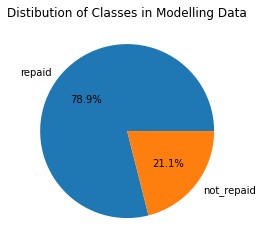

In [68]:
values_repaid = data["Class_repaid"].sum()
values_not_repaid = len(data) - values_repaid
plt.pie([values_repaid, values_not_repaid], labels=["repaid", "not_repaid"], autopct='%1.1f%%')
plt.title("Distibution of Classes in Modelling Data")
plt.savefig("Class-Distribution_final.data.png")

In [ ]:
# Trying Different Types of Input Data for Logistic Regression to see the following effects:
#### Scaling
#### Balancing
#### Different Types of Input data

### Unfortunatly CV takes too long. As this isn't that important we run it without a cv


add_replaced_features = [True, False]
add_replacement = [True, False]
scaling = [True, False]
weight_options = ["balanced", None]

input_options = list(itertools.product(*[add_replaced_features, add_replacement, scaling, weight_options]))
df_index = pd.MultiIndex.from_tuples(input_options, names=["replaced_features", "replacement", "scale", "class_weight"])
overview = pd.DataFrame(index=df_index, columns=["Balanced_Accuracy","Accuracy", "Pecision", "Recall", "Confusion-Matrix", "AUC", "most_relevant_features"])

for input_option in input_options:

    print(input_option)

    # select input data and split data
    X_train_df, X_test_df, y_train, y_test = select_and_split_data_for_model(data,
                                                                   add_replaced_features=input_option[0],
                                                                   add_replacement=input_option[1],
                                                                   test_size=0.2,
                                                                   scaling=input_option[2])
    X_train = X_train_df.to_numpy()
    X_test = X_test_df.to_numpy()

    # create model
    clf_log_reg = LogisticRegression(random_state=42, max_iter=1000,
                                          class_weight=input_option[3])

    # train model
    clf_log_reg.fit(X_train, y_train)

    # Predict Data
    y_pred = clf_log_reg.predict(X_test)

    # Evaluate Model
    performance = analyse_results(clf_log_reg, y_pred, y_test, X_test_df, show_fig=False, feature_info=True)

    overview.loc[input_option] = list(performance.values())


overview.to_csv("Different_Options_Log_Reg.csv")

In [10]:
# data and overview frame for Part 1

X_train_p1, X_test_p1, y_train_p1, y_test_p1, feature_names = select_and_split_data_for_model(data, add_replaced_features=False,
                                                                               add_replacement = True, test_size=0.2,
                                                                               scaling=True)

np.save("Data_Part1_Xtrain", X_train_p1)
np.save("Data_Part1_Xtest", X_test_p1)
np.save("Data_Part1_ytest", y_test_p1)
np.save("Data_Part1_ytrain", y_train_p1)

save_list_to_file("Data_Part1_Feature_names", feature_names)


In [4]:
X_train_p1 = np.load("Data_Part1_Xtrain.npy")
X_test_p1 = np.load("Data_Part1_Xtest.npy")
y_test_p1 = np.load("Data_Part1_ytest.npy")
y_train_p1 = np.load("Data_Part1_ytrain.npy")

feature_names = load_textfile_to_list("Data_Part1_Feature_names")


Considering the large impact of both scaling and the balancing of the classes will henceforth only use the scaled data
and the balancing parameters for classifiers. To reduce the multi-coliniarity we will only use the relative versions of
the features we calculated.


<b> Logistic Regression </b>

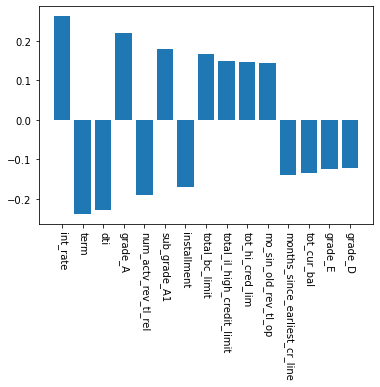

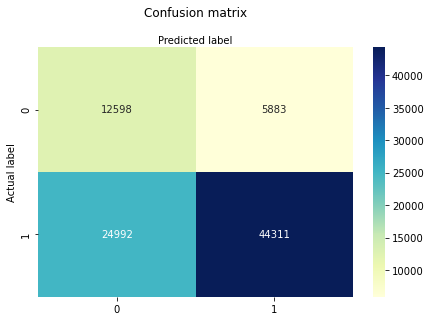

{'Balances_Accuracy': 0.6605268801148418,
 'Accuracy': 0.6482844254078192,
 'Precision': 0.88279475634538,
 'Recall': 0.6393806905905949,
 'Confusion-Matrix': array([[12598,  5883],
        [24992, 44311]], dtype=int64),
 'AUC': 0.6605268801148418}

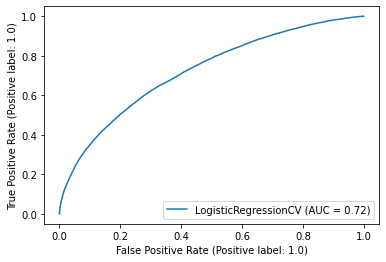

In [7]:
# create model - use cv to ensure good parameters beta
# use auc as parameter to optimise by
clf_log_reg_p1_auc = LogisticRegressionCV(random_state=42, max_iter=700, cv=10, class_weight="balanced",
                                   n_jobs=3, scoring="roc_auc")

clf_log_reg_p1_auc.fit(X_train_p1, y_train_p1)

# Predict Data
y_pred = clf_log_reg_p1_auc.predict(X_test_p1)

# Evaluate Model
performance_log_reg_p1_auc = analyse_results(clf_log_reg_p1_auc, y_pred, y_test_p1, X_test, show_fig=True,
                                             feature_info=True)

performance_log_reg_p1_auc

In [5]:
# create model - see how result change if optimising by precision
clf_log_reg_p1_prec = LogisticRegressionCV(random_state=42, max_iter=700, cv=10, class_weight="balanced",
                                   n_jobs=3, scoring="precision")

clf_log_reg_p1_prec.fit(X_train_p1, y_train_p1)
clf_log_reg_p1_prec.scores_


{1.0: array([[0.88567687, 0.88588513, 0.88573577, 0.88569137, 0.8857415 ,
         0.8857415 , 0.8857415 , 0.88574723, 0.88573577, 0.8857415 ],
        [0.88750314, 0.88712584, 0.88658866, 0.88659433, 0.88662166,
         0.88667734, 0.88668867, 0.886683  , 0.88668867, 0.886683  ],
        [0.88084517, 0.88146243, 0.88112751, 0.88105097, 0.88116128,
         0.88116128, 0.88116128, 0.88121057, 0.88116713, 0.88116128],
        [0.88415256, 0.88472081, 0.88475573, 0.88473615, 0.88481994,
         0.8848141 , 0.88481994, 0.8848141 , 0.88481994, 0.8848141 ],
        [0.88906063, 0.88806937, 0.8888335 , 0.88873934, 0.88867285,
         0.88867285, 0.88867285, 0.8886784 , 0.88867285, 0.88867285],
        [0.88734019, 0.88758817, 0.88657685, 0.88611194, 0.88603491,
         0.88603491, 0.88602354, 0.88602354, 0.88602354, 0.88602923],
        [0.88332919, 0.88399026, 0.88356062, 0.88304412, 0.88281366,
         0.88276409, 0.88281366, 0.88280785, 0.88280785, 0.88280204],
        [0.88471998, 0

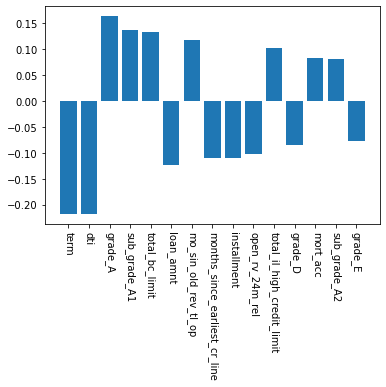

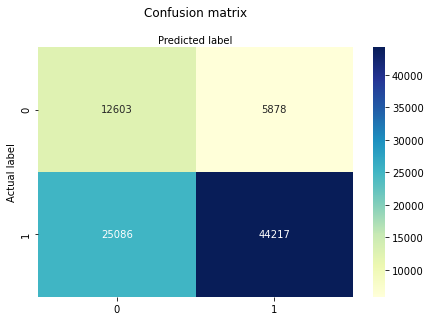

{'Balances_Accuracy': 0.659983972860386,
 'Accuracy': 0.6472705732251891,
 'Precision': 0.8826629404132149,
 'Recall': 0.6380243279511709,
 'Confusion-Matrix': array([[12603,  5878],
        [25086, 44217]], dtype=int64),
 'AUC': 0.659983972860386}

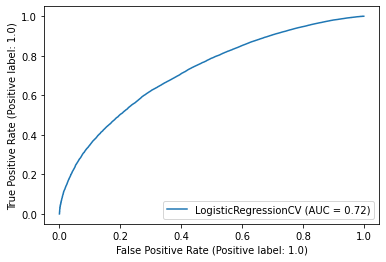

In [6]:
# Predict Data
y_pred = clf_log_reg_p1_prec.predict(X_test_p1)

# Evaluate Model
performance_log_reg_p1_prec = analyse_results(clf_log_reg_p1_prec, y_pred, y_test_p1, X_test_p1, show_fig=True,
                                              feature_info=True)

performance_log_reg_p1_prec

In [17]:
### If we use PCA we lose all information on the features.
### But as we are only interested in the predictions this can be done

from sklearn.decomposition import PCA

for components in [245, 220, 200, 180, 150, 130, 100, 80, 50, 10, 5]:
    pca = PCA(n_components=components)

    pca.fit(X_train_p1)

    print(f"{components} explain {pca.explained_variance_ratio_.mean()} on average "
          f"and in total {pca.explained_variance_ratio_.sum()}")

245 explain 0.004081632653061225 on average and in total 1.0
220 explain 0.004544765808453921 on average and in total 0.9998484778598626
200 explain 0.0049600405896808 on average and in total 0.99200811793616
180 explain 0.005395500993780281 on average and in total 0.9711901788804507
150 explain 0.006067144060094365 on average and in total 0.9100716090141548
130 explain 0.006439410526628553 on average and in total 0.8371233684617119
100 explain 0.00714395558647358 on average and in total 0.714395558647358
80 explain 0.00787634982904852 on average and in total 0.6301079863238817
50 explain 0.009981732456530064 on average and in total 0.4990866228265032
10 explain 0.020381395894802107 on average and in total 0.20381395894802107
5 explain 0.026612793507905286 on average and in total 0.13306396753952643


Best parameter (CV score=0.725):
{'pca__n_components': 245}


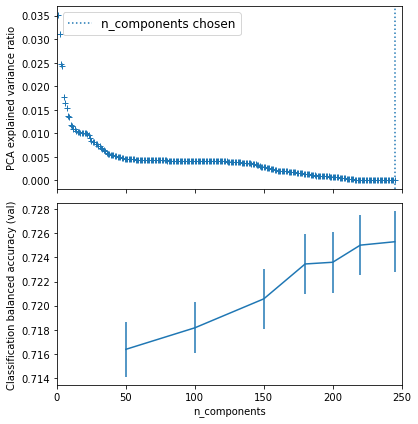

In [6]:
## pca - optimised with AUC

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.05)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [50, 100, 150, 180, 200, 220, 245],
}
search = GridSearchCV(pipe, param_grid, n_jobs=3, cv=3, scoring="roc_auc")
search.fit(X_train_p1, y_train_p1)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_train_p1)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification balanced accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(0, 250)

plt.tight_layout()
plt.show()


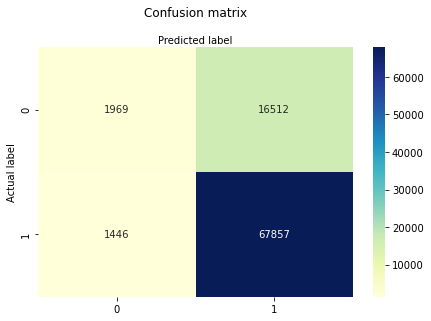

{'Balances_Accuracy': 0.5428384780861554,
 'Accuracy': 0.7954296910598743,
 'Precision': 0.8042883049461295,
 'Recall': 0.9791351023765205,
 'Confusion-Matrix': array([[ 1969, 16512],
        [ 1446, 67857]], dtype=int64),
 'AUC': 0.5428384780861554}

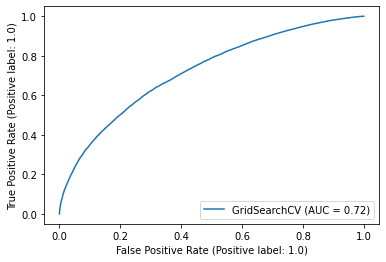

In [7]:
# Predict Data
y_pred = search.predict(X_test_p1)

# Evaluate Model
performance_pca = analyse_results(search, y_pred, y_test_p1, X_test_p1, show_fig=True, feature_info=False)

performance_pca


Best parameter (CV score=0.804):
{'pca__n_components': 245}


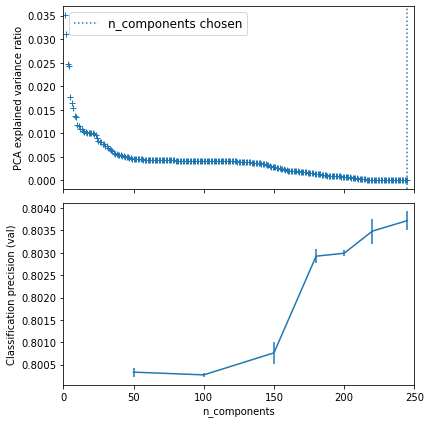

In [10]:
###PCA optimised with Precision

## Define a pipeline to search for the best combination of PCA truncation
## and classifier regularization.
pca_prec = PCA()
# set the tolerance to a large value to make the example faster
logistic_prec = LogisticRegression(max_iter=10000, tol=0.05)
pipe_prec = Pipeline(steps=[('pca', pca_prec), ('logistic', logistic_prec)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid_prec = {
    'pca__n_components': [50, 100, 150, 180, 200, 220, 245],
}
search_prec = GridSearchCV(pipe_prec, param_grid_prec, n_jobs=3, cv=3, scoring="precision")
search_prec.fit(X_train_p1, y_train_p1)
print("Best parameter (CV score=%0.3f):" % search_prec.best_score_)
print(search_prec.best_params_)

# Plot the PCA spectrum
pca_prec.fit(X_train_p1)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca_prec.n_components_ + 1),
         pca_prec.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search_prec.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results_prec = pd.DataFrame(search_prec.cv_results_)
components_col_prec = 'param_pca__n_components'
best_clfs_prec = results_prec.groupby(components_col_prec).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs_prec.plot(x=components_col_prec, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification precision (val)')
ax1.set_xlabel('n_components')

plt.xlim(0, 250)

plt.tight_layout()
plt.show()


In [ ]:
# Predict Data
y_pred = search.predict(X_test_p1)

# Evaluate Model
performance_pca = analyse_results(search, y_pred, y_test_p1, X_test_p1, show_fig=True, feature_info=False)

performance_pca

In [ ]:
#### SVM
from sklearn.svm import LinearSVC
X_train, X_test, y_train_svm, y_test_svm, feature_names = select_and_split_data_for_model(data,
                                                                                              add_replaced_features=False,
                                                                                              add_replacement = True,
                                                                                              test_size=0.2,
                                                                                              scaling=False)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_svm = scaler.transform(X_train)
X_test_svm = scaler.transform(X_test)

svm_linear = LinearSVC(class_weight="balanced", tol=0.05, max_iter=200)

svm_linear.fit(X_train_svm, y_train_svm)


In [ ]:
svm_linear = NuSVC(class_weight="balanced", tol=0.05, max_iter=200, kernel="linear")

svm_linear.fit(X_train_svm, y_train_svm)


In [9]:
### Keep data in it's raw state as the main advantage of decision trees is the easiy comprehension of the model
### And the possibility to apply the model easily to the data at hand (in the implementation)

from sklearn.tree import DecisionTreeClassifier
X_train_trees, X_test_trees, y_train_trees, y_test_trees, feature_names = select_and_split_data_for_model(data,
                                                                                              add_replaced_features=True,
                                                                                              add_replacement = True,
                                                                                              test_size=0.2,
                                                                                              scaling=False)

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

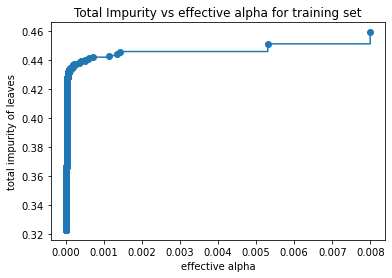

In [54]:
### We tried a few different parameters for the tree - we couldn't compute complete
### cross validation for hyperparameter optimisation though

tree = DecisionTreeClassifier(class_weight="balanced", random_state=42, min_samples_split=100, max_depth=20)


path = tree.cost_complexity_pruning_path(X_train_trees, y_train_trees)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

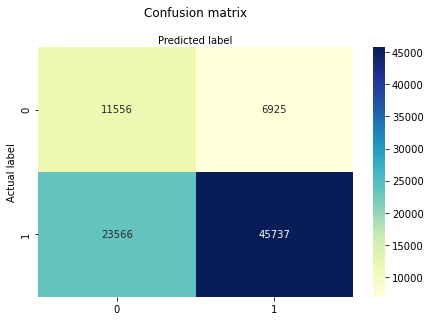

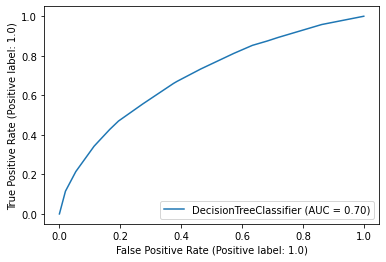

In [78]:
tree = DecisionTreeClassifier(class_weight="balanced", random_state=42, min_samples_split=100, max_depth=20,
                              ccp_alpha=0.0003)


tree.fit(X_train_trees, y_train_trees)

y_pred_tree = tree.predict(X_test_trees)

performance = analyse_results(tree, y_pred_tree, y_test_trees, X_test_trees)

In [79]:
performance


{'Balances_Accuracy': 0.6426239198293766,
 'Accuracy': 0.6526587988699535,
 'Precision': 0.8685010064182902,
 'Recall': 0.6599570004184523,
 'Confusion-Matrix': array([[11556,  6925],
        [23566, 45737]], dtype=int64),
 'AUC': 0.6426239198293766}

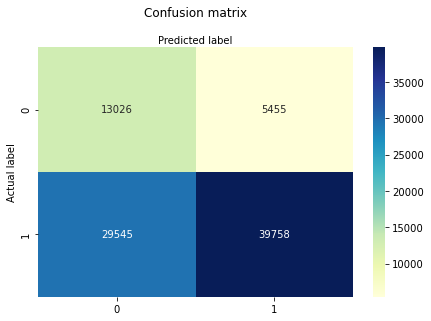

{'Balances_Accuracy': 0.6392578342640852,
 'Accuracy': 0.601294085482548,
 'Precision': 0.8793488598411962,
 'Recall': 0.5736836789172186,
 'Confusion-Matrix': array([[13026,  5455],
        [29545, 39758]], dtype=int64),
 'AUC': 0.6392578342640852}

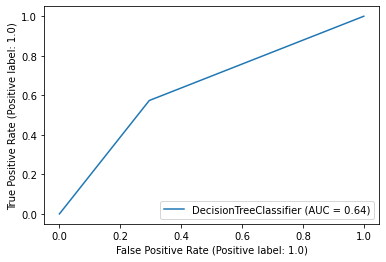

In [96]:
tree = DecisionTreeClassifier(class_weight="balanced", random_state=42, min_samples_split=100, max_depth=20,
                              ccp_alpha=0.01)


tree.fit(X_train_trees, y_train_trees)

y_pred_tree = tree.predict(X_test_trees)

performance = analyse_results(tree, y_pred_tree, y_test_trees, X_test_trees)
performance

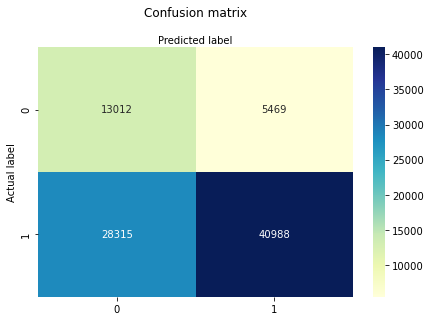

{'Balances_Accuracy': 0.6477531415967481, 'Accuracy': 0.6151462681126402, 'Precision': 0.882278235787933, 'Recall': 0.5914318283479791, 'Confusion-Matrix': array([[13012,  5469],
       [28315, 40988]], dtype=int64), 'AUC': 0.6477531415967481}


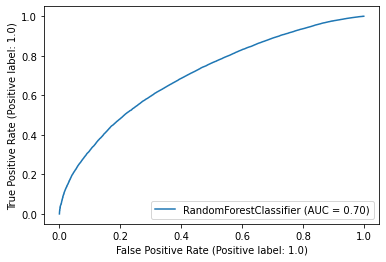

In [97]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(class_weight="balanced", n_jobs=3, max_depth=2,
                                n_estimators=400, max_samples=0.6, max_features="sqrt")

forest.fit(X_train_trees, y_train_trees)

y_pred_forest = forest.predict(X_test_trees)

performance = analyse_results(forest, y_pred_forest, y_test_trees, X_test_trees)
print(performance)


In [98]:
### As comprehensability of the model is lost entirely when using ensemble learners we can see whether the model
### improves when using scaled data (different ranges might make a difference considering extremes)

X_train_forest_scaled, X_test_forest_scaled, y_train_forest_scaled, y_test_forest_scaled, feature_names = select_and_split_data_for_model(data,
                                                                                              add_replaced_features=True,
                                                                                              add_replacement = True,
                                                                                              test_size=0.2,
                                                                                              scaling=True)



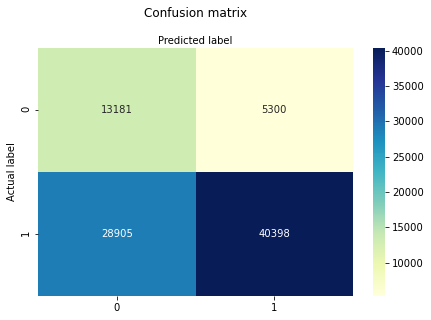

{'Balances_Accuracy': 0.6480687350169816, 'Accuracy': 0.610350405540873, 'Precision': 0.8840211825462821, 'Recall': 0.5829184883771266, 'Confusion-Matrix': array([[13181,  5300],
       [28905, 40398]], dtype=int64), 'AUC': 0.6480687350169817}


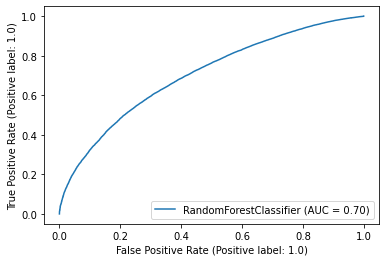

In [99]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(class_weight="balanced", n_jobs=3, max_depth=2,
                                n_estimators=400, max_samples=0.6, max_features="sqrt")

forest.fit(X_train_forest_scaled, y_train_forest_scaled)

y_pred_forest = forest.predict(X_test_forest_scaled)

performance = analyse_results(forest, y_pred_forest, y_test_forest_scaled, X_test_forest_scaled)
print(performance)

##### not really

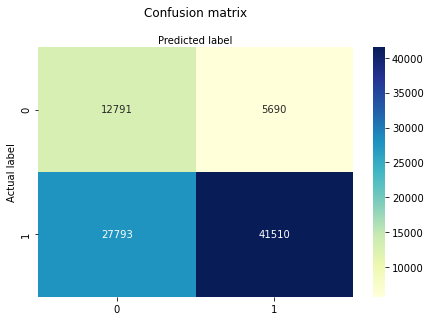

{'Balances_Accuracy': 0.6455400986452924, 'Accuracy': 0.6185751389774902, 'Precision': 0.8794491525423729, 'Recall': 0.5989639698137166, 'Confusion-Matrix': array([[12791,  5690],
       [27793, 41510]], dtype=int64), 'AUC': 0.6455400986452924}


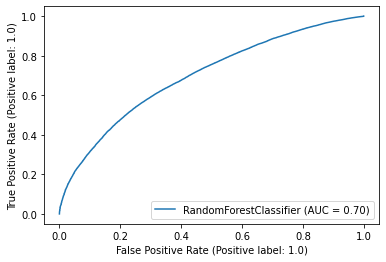

In [100]:
#### how about normalised data?
X_train_forest, X_test_forest, y_train_forest, y_test_forest, feature_names = select_and_split_data_for_model(data,
                                                                                              add_replaced_features=True,
                                                                                              add_replacement = True,
                                                                                              test_size=0.2,
                                                                                              scaling=False)
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_forest_normalised = scaler.transform(X_train_forest)
X_test_forest_normalised = scaler.transform(X_test_forest)

from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(class_weight="balanced", n_jobs=3, max_depth=1,
                                n_estimators=400, max_samples=0.6, max_features="sqrt")

forest.fit(X_train_forest_normalised, y_train_forest)

y_pred_forest = forest.predict(X_test_forest_normalised)

performance = analyse_results(forest, y_pred_forest, y_test_trees, X_test_forest_normalised)
print(performance)
### also no real difference